In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [3]:
import matplotlib as mpl
print('numpy :', np.__version__)
print('pandas :', pd.__version__)
print('tensorflow :', tf.__version__)
print('matplotlib : ', mpl.__version__)

numpy : 1.19.5
pandas : 1.1.5
tensorflow : 2.6.0
matplotlib :  3.2.2


In [4]:
tfds.disable_progress_bar()
seeds = 42

np.random.seed(seeds)
tf.random.set_seed(seeds)

In [5]:
train_ds, val_ds = tfds.load(
    'tf_flowers', split = ['train[:85%]' , 'train[85%:]'], as_supervised = True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


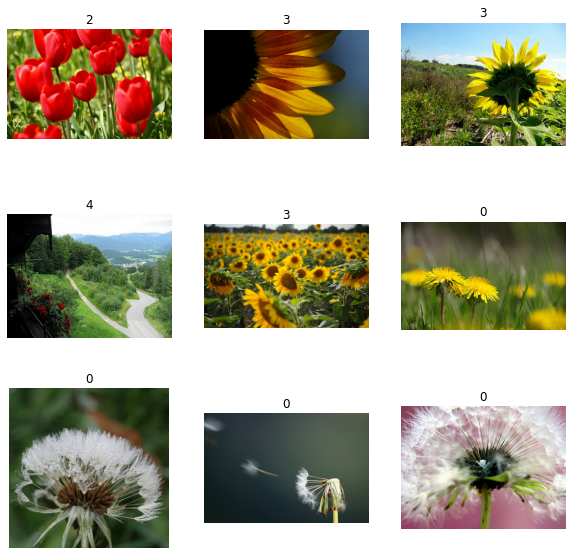

In [6]:
plt.figure(figsize = (10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

In [7]:
resize_to = 384
crop_to = 224
batch_size = 64
steps_per_epoch = 10
auto = tf.data.AUTOTUNE
num_classes = 5
schedule_length = (
    500
)
schedule_boundaries = [
    200,
    300,
    400,
] 

In [8]:
schedule_length = schedule_length * 512 / batch_size

@tf.function
def preprocess_train(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image, (resize_to, resize_to))
  image = tf.image.random_crop(image, (crop_to, crop_to, 3))
  image /= 255.0
  return (image, label)

@tf.function
def preprocess_test(image, label):
  image = tf.image.resize(image, (resize_to, resize_to))
  image /= 255.0
  return (image, label)

dataset_num_train_examples = tf.data.experimental.cardinality(train_ds).numpy()

repeat_count = int(
    schedule_length * batch_size / dataset_num_train_examples * steps_per_epoch
)

repeat_count += 50 + 1

In [12]:
# pipeline for train
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)
    .map(preprocess_train, num_parallel_calls = auto)
    .batch(batch_size)
    .prefetch(auto)
)

# pipeline for validation
pipeline_val = (
    val_ds.map(preprocess_test, num_parallel_calls = auto)
    .batch(batch_size)
    .prefetch(auto)
)

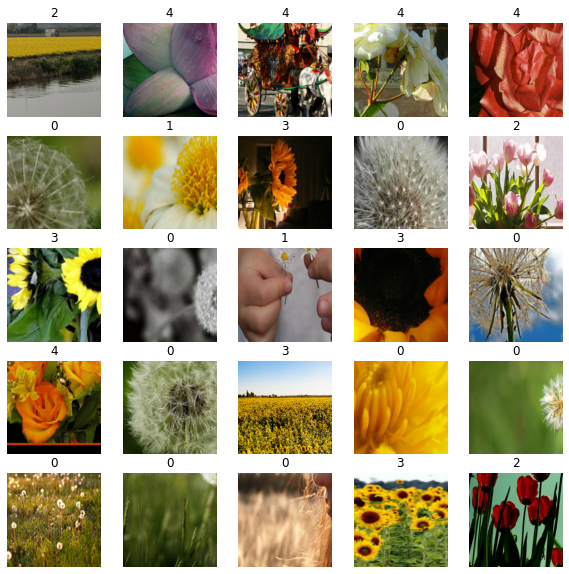

In [13]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize = (10, 10) )
for n in range(25):
  ax = plt.subplot(5, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(label_batch[n].numpy())
  plt.axis('off')

In [14]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [15]:
class HJ_BIT_Model(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer = "zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

model = HJ_BIT_Model(num_classes = num_classes, module = bit_module)

In [16]:
learning_rate = 0.003 * batch_size / 512

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = schedule_boundaries,
    values = [
              learning_rate,
              learning_rate * 0.1,
              learning_rate * 0.01,
              learning_rate * 0.001,
    ],
)

optimizer = keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [17]:
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

In [18]:
train_callbacks = [
                   keras.callbacks.EarlyStopping(
                       monitor = 'val_accuracy', patience = 2, restore_best_weights = True
                   )
]

In [19]:
history = model.fit(
    pipeline_train,
    batch_size = batch_size,
    epochs = int(schedule_length / steps_per_epoch),
    steps_per_epoch = steps_per_epoch,
    validation_data = pipeline_val,
    callbacks = train_callbacks
)

Epoch 1/400
10/10 [==============================] - 85s 4s/step - loss: 0.7405 - accuracy: 0.7984 - val_loss: 0.1948 - val_accuracy: 0.9564
Epoch 2/400
10/10 [==============================] - 29s 3s/step - loss: 0.2019 - accuracy: 0.9312 - val_loss: 0.1054 - val_accuracy: 0.9673
Epoch 3/400
10/10 [==============================] - 29s 3s/step - loss: 0.1595 - accuracy: 0.9484 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 4/400
10/10 [==============================] - 29s 3s/step - loss: 0.1392 - accuracy: 0.9406 - val_loss: 0.0846 - val_accuracy: 0.9709
Epoch 5/400
10/10 [==============================] - 29s 3s/step - loss: 0.1092 - accuracy: 0.9594 - val_loss: 0.0885 - val_accuracy: 0.9745
Epoch 6/400
10/10 [==============================] - 29s 3s/step - loss: 0.1127 - accuracy: 0.9563 - val_loss: 0.0884 - val_accuracy: 0.9727
Epoch 7/400
10/10 [==============================] - 29s 3s/step - loss: 0.1040 - accuracy: 0.9688 - val_loss: 0.0744 - val_accuracy: 0.9764
Epoch 8/400
1

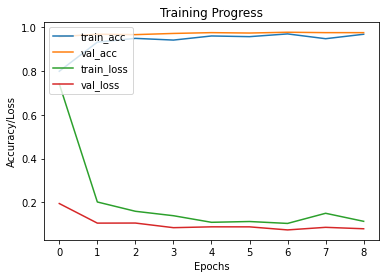

In [20]:
# 훈련, 검증 항목 시각화
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [22]:
# 모델 정확도 평가
accuracy = model.evaluate(pipeline_val)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 21s 2s/step - loss: 0.0744 - accuracy: 0.9764
Accuracy: 97.64%
